## POS tagging using modified Viterbi

#### Important Note:
- Please download the test file Test_sentences.txt or similar file with same name and keep it in the same folder where this notebook is saved.
- The Test_sentences.txt used for testing this program can be downloaded from <a href='https://cdn.upgrad.com/UpGrad/temp/9dca5f3b-53c3-47e1-86d5-5ec5dafad6f0/Test_sentences.txt'>here</a> 

In [1]:
"""
###########################################################################################################################
##  
##  Program Name    : POS tagging using modified Viterbi
##
##  Description     : To modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques.
##
##  Author          : Sunil Yousef
##  
###########################################################################################################################
"""

#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

C:\Users\lenovo\Anaconda3\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


## Data Preparation

Reading the Treebank dataset of NLTK with the 'universal' tagset. 
- The Universal tagset of NLTK comprises only 12 coarse tag classes as follows: Verb, Noun, Pronouns, Adjectives, Adverbs, Adpositions, Conjunctions, Determiners, Cardinal Numbers, Particles, Other/ Foreign words, Punctuations.
- Note that using only 12 coarse classes (compared to the 46 fine classes such as NNP, VBD etc.) will make the Viterbi algorithm faster as well.

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

The tagged sentences are in the form of a list of tuples, where the first element of the tuple is a word and the second element is the POS tag of the word.

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05, random_state=42)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196


[[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('1991-2000', 'NUM'), ('and', 'CONJ'), ('2009', 'NUM'), (',', '.'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('a', 'DET'), ('Chemical', 'NOUN'), ('Securities', 'NOUN'), ('Inc.', 'NOUN'), ('group', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.20', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.272', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('2009', 'NUM'), ('.', '.')], [('``', '.'), ('They', 'PRON'), ('were', 'VERB

Getting list of tagged words

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95589

Get the tokens from train tagged words

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']

Create a vocabulary

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12109


Verify that the number of tags is 12

In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

Check the 12 tags

In [9]:
print(T)

{'PRT', 'ADV', 'ADP', 'NOUN', 'NUM', 'DET', 'ADJ', 'CONJ', 'X', 'VERB', 'PRON', '.'}


## Build the vanilla Viterbi based POS tagger

#### UDF for computing Emission Probabilities

In [10]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

Testing Emission Probabilities udf

In [11]:
# testing Emission Probabilities udf
# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'))

# will
print("\n", "will")
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(27, 6077)
(0, 12885)
(0, 27423)

 will
(1, 27423)
(268, 12885)

 book
(7, 27423)
(1, 12885)


#### UDF for computing Transition Probabilities

- compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

Testing Transition Probabilities udf

In [13]:
# Testing Transition Probabilities udf
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('.', 'NOUN'))
print(t2_given_t1('PRON', 'PRON'))
print(t2_given_t1('VERB', 'NOUN'))

#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('PRON', '.'))

(4234, 6077)
(4234, 6077)
(5302, 8284)
(1429, 12885)
(6559, 27423)
(21, 2618)
(4058, 27423)
(1929, 11118)
(984, 11118)
(2481, 11118)
(727, 11118)


#### Transition matrix of tags
Now Compute the transition probabilities matrix and finally use the emission and the transition probabilities to write the Viterbi algorithm for tagging a given sequence of words.

In [14]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix

array([[1.63452106e-03, 1.01340311e-02, 2.15756781e-02, 2.42562935e-01,
        5.85158542e-02, 1.00359596e-01, 8.63027126e-02, 2.28832942e-03,
        1.34030730e-02, 4.02745992e-01, 1.89604443e-02, 4.15168367e-02],
       [1.36212623e-02, 8.10631216e-02, 1.19601332e-01, 3.08970101e-02,
        3.05647831e-02, 6.71096370e-02, 1.30232558e-01, 6.31229253e-03,
        2.35880390e-02, 3.44518274e-01, 1.56146176e-02, 1.36877075e-01],
       [1.49812736e-03, 1.31621184e-02, 1.72284637e-02, 3.21776360e-01,
        6.29213452e-02, 3.26377749e-01, 1.05296947e-01, 8.56072758e-04,
        3.40288915e-02, 8.23970046e-03, 6.91278726e-02, 3.94863561e-02],
       [4.38318215e-02, 1.68836378e-02, 1.76275387e-01, 2.64631867e-01,
        9.62695573e-03, 1.33099956e-02, 1.22889541e-02, 4.19356003e-02,
        2.91361269e-02, 1.47977978e-01, 4.92287474e-03, 2.39178792e-01],
       [2.79512331e-02, 2.97353556e-03, 3.47903669e-02, 3.55337501e-01,
        1.84061855e-01, 3.27088917e-03, 3.41956578e-02, 1.33

In [15]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,PRT,ADV,ADP,NOUN,NUM,DET,ADJ,CONJ,X,VERB,PRON,.
PRT,0.001635,0.010134,0.021576,0.242563,0.058516,0.100360,0.086303,0.002288,0.013403,0.402746,0.018960,0.041517
ADV,0.013621,0.081063,0.119601,0.030897,0.030565,0.067110,0.130233,0.006312,0.023588,0.344518,0.015615,0.136877
ADP,0.001498,0.013162,0.017228,0.321776,0.062921,0.326378,0.105297,0.000856,0.034029,0.008240,0.069128,0.039486
NOUN,0.043832,0.016884,0.176275,0.264632,0.009627,0.013310,0.012289,0.041936,0.029136,0.147978,0.004923,0.239179
NUM,0.027951,0.002974,0.034790,0.355338,0.184062,0.003271,0.034196,0.013381,0.206661,0.017544,0.001487,0.118347
DET,0.000241,0.012313,0.009054,0.640029,0.021970,0.005311,0.204973,0.000483,0.045509,0.038387,0.003742,0.017986
ADJ,0.010861,0.004608,0.078986,0.696725,0.020405,0.005101,0.066645,0.016949,0.021392,0.012342,0.000658,0.065328
CONJ,0.004693,0.055842,0.054435,0.349132,0.042234,0.121539,0.116847,0.000469,0.007977,0.153918,0.058658,0.034256
X,0.185787,0.025175,0.142925,0.061345,0.002709,0.055131,0.016571,0.010357,0.076482,0.203633,0.056087,0.163799
VERB,0.031121,0.082577,0.090493,0.110904,0.022817,0.133101,0.064649,0.005588,0.218005,0.169189,0.036244,0.035312


Check the probability of each tags.

In [16]:
tags_df.loc['.', :]

PRT     0.002339
ADV     0.052078
ADP     0.091114
NOUN    0.223152
NUM     0.080500
DET     0.173502
ADJ     0.044972
CONJ    0.057924
X       0.026623
VERB    0.088505
PRON    0.065389
.       0.093812
Name: ., dtype: float32

In [17]:
first_tag = tags_df.loc['.', :].index[0]
print(f'{first_tag} is the first tag on the current tag list')

PRT is the first tag on the current tag list


#### Heatmap of tags matrix

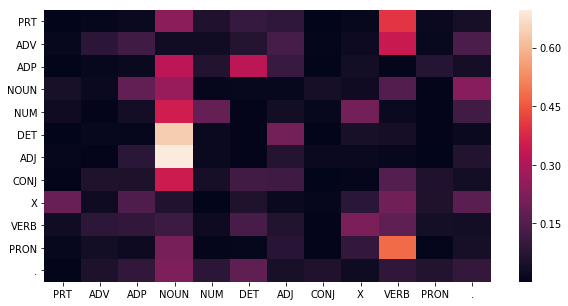

In [18]:
# plot heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(10, 5))
sns.heatmap(tags_df)
plt.show()

#### Frequent tags

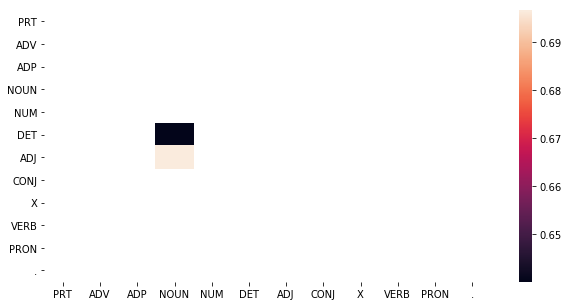

In [19]:
# plot frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(10, 5))
sns.heatmap(tags_frequent)
plt.show()

In [20]:
len(train_tagged_words)

95589

#### UDF - Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. 

We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

###### The Viterbi algorithm works as follows:

For each word, we compute the P(tag|word) for each tag in the tag set and then assign the tag having the max P(tag/word).

P(tag|word) = (emission probability of the word-tag pair) * (transition probability from the previous tag).

As we move along each word, we keep on storing the assigned tags in a list. As we progress further down the sequence, each word uses the tag of the previous token to compute the transition probabilities.

In [21]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            # Calculate Transition probability for each tag. 
            # For the first word of a sentence, compute P(tag|'.') 
            # and for the rest compute P(tag|previous_tag)
            if key == 0:
                transition_p = tags_df.loc['.', tag] #tag for the first word is calculated taking '.' as the previous tag
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating on Test Set

- Running on entire test dataset would take more than 3-4hrs. 
- Let's test our Viterbi algorithm on a few sample sentences of test dataset

In [22]:
random.seed(1234)

# choose some random sents
rndom = [random.randint(1, len(test_set)) for x in range(10)]
rndom

[113, 30, 2, 24, 150, 9, 172, 178, 22, 26]

In [23]:
# list of sents
test_run = [test_set[i] for i in rndom]
test_run

[[('Shearson', 'NOUN'),
  ('``', '.'),
  ('really', 'ADV'),
  ('only', 'ADV'),
  ('has', 'VERB'),
  ('$', '.'),
  ('300', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('of', 'ADP'),
  ('capital', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('Mr.', 'NOUN'),
  ('Bowman', 'NOUN'),
  ('of', 'ADP'),
  ('S&P', 'NOUN'),
  ('.', '.')],
 [('ShareData', 'NOUN'),
  ('develops', 'VERB'),
  ('and', 'CONJ'),
  ('markets', 'VERB'),
  ('low-cost', 'ADJ'),
  ('software', 'NOUN'),
  (',', '.'),
  ('peripheral', 'ADJ'),
  ('equipment', 'NOUN'),
  ('and', 'CONJ'),
  ('accessories', 'NOUN'),
  ('for', 'ADP'),
  ('computers', 'NOUN'),
  ('.', '.')],
 [('Moscow', 'NOUN'),
  ('has', 'VERB'),
  ('settled', 'VERB'),
  ('pre-1917', 'ADJ'),
  ('debts', 'NOUN'),
  ('with', 'ADP'),
  ('other', 'ADJ'),
  ('countries', 'NOUN'),
  ('in', 'ADP'),
  ('recent', 'ADJ'),
  ('years', 'NOUN'),
  ('at', 'ADP'),
  ('less', 'ADJ'),
  ('than', 'ADP'),
  ('face', 'NOUN'),
  ('value', 'NOUN'),


In [24]:
# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]
test_run_base

[('Shearson', 'NOUN'),
 ('``', '.'),
 ('really', 'ADV'),
 ('only', 'ADV'),
 ('has', 'VERB'),
 ('$', '.'),
 ('300', 'NUM'),
 ('million', 'NUM'),
 ('*U*', 'X'),
 ('of', 'ADP'),
 ('capital', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('says', 'VERB'),
 ('*T*-1', 'X'),
 ('Mr.', 'NOUN'),
 ('Bowman', 'NOUN'),
 ('of', 'ADP'),
 ('S&P', 'NOUN'),
 ('.', '.'),
 ('ShareData', 'NOUN'),
 ('develops', 'VERB'),
 ('and', 'CONJ'),
 ('markets', 'VERB'),
 ('low-cost', 'ADJ'),
 ('software', 'NOUN'),
 (',', '.'),
 ('peripheral', 'ADJ'),
 ('equipment', 'NOUN'),
 ('and', 'CONJ'),
 ('accessories', 'NOUN'),
 ('for', 'ADP'),
 ('computers', 'NOUN'),
 ('.', '.'),
 ('Moscow', 'NOUN'),
 ('has', 'VERB'),
 ('settled', 'VERB'),
 ('pre-1917', 'ADJ'),
 ('debts', 'NOUN'),
 ('with', 'ADP'),
 ('other', 'ADJ'),
 ('countries', 'NOUN'),
 ('in', 'ADP'),
 ('recent', 'ADJ'),
 ('years', 'NOUN'),
 ('at', 'ADP'),
 ('less', 'ADJ'),
 ('than', 'ADP'),
 ('face', 'NOUN'),
 ('value', 'NOUN'),
 ('.', '.'),
 ('When', 'ADV'),
 ('test', 'NOUN'),
 (

In [25]:
# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_tagged_words

['Shearson',
 '``',
 'really',
 'only',
 'has',
 '$',
 '300',
 'million',
 '*U*',
 'of',
 'capital',
 ',',
 "''",
 'says',
 '*T*-1',
 'Mr.',
 'Bowman',
 'of',
 'S&P',
 '.',
 'ShareData',
 'develops',
 'and',
 'markets',
 'low-cost',
 'software',
 ',',
 'peripheral',
 'equipment',
 'and',
 'accessories',
 'for',
 'computers',
 '.',
 'Moscow',
 'has',
 'settled',
 'pre-1917',
 'debts',
 'with',
 'other',
 'countries',
 'in',
 'recent',
 'years',
 'at',
 'less',
 'than',
 'face',
 'value',
 '.',
 'When',
 'test',
 'booklets',
 'were',
 'passed',
 '*-1',
 'out',
 '48',
 'hours',
 'ahead',
 'of',
 'time',
 '*T*-2',
 ',',
 'she',
 'says',
 '0',
 'she',
 'copied',
 'questions',
 'in',
 'the',
 'social',
 'studies',
 'section',
 'and',
 'gave',
 'the',
 'answers',
 'to',
 'students',
 '.',
 'The',
 'Life',
 'Insurance',
 'Co.',
 'of',
 'Georgia',
 'has',
 'officially',
 'opened',
 'an',
 'office',
 'in',
 'Taipei',
 '.',
 'Big',
 'Board',
 'volume',
 'totaled',
 '154.2',
 'million',
 'shares',

Tag the test sentences

In [26]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

print(tagged_seq)

Time taken in seconds:  57.55651521682739
[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'PRT'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'PRT'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'PRT'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets', 

#### Evaluate the accuracy of the Viterbi algorithm on the test dataset. 
Predicting the tags of the entire test-set takes about 3-4 hours. So, we'll compute the tagging accuracy on a few randomly chosen sentences.

In [27]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(f'Accuracy is ~{round(accuracy*100)}%')

Accuracy is ~91%


#### Check the incorrectly tagged cases

In [28]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('ShareData', 'NOUN'), (('develops', 'PRT'), ('develops', 'VERB'))],
 [('and', 'CONJ'), (('markets', 'NOUN'), ('markets', 'VERB'))],
 [('markets', 'VERB'), (('low-cost', 'PRT'), ('low-cost', 'ADJ'))],
 [('settled', 'VERB'), (('pre-1917', 'PRT'), ('pre-1917', 'ADJ'))],
 [('When', 'ADV'), (('test', 'VERB'), ('test', 'NOUN'))],
 [('*-1', 'X'), (('out', 'PRT'), ('out', 'ADV'))],
 [('she', 'PRON'), (('copied', 'PRT'), ('copied', 'VERB'))],
 [('totaled', 'VERB'), (('154.2', 'PRT'), ('154.2', 'NUM'))],
 [('been', 'VERB'), (('enormously', 'PRT'), ('enormously', 'ADV'))],
 [('enormously', 'ADV'), (('frustrating', 'PRT'), ('frustrating', 'VERB'))],
 [('computer', 'NOUN'), (('science', 'PRT'), ('science', 'NOUN'))],
 [('was', 'VERB'), (('raring', 'PRT'), ('raring', 'ADJ'))],
 [('to', 'PRT'), (('invent', 'PRT'), ('invent', 'VERB'))],
 [('another', 'DET'), (('Walkman', 'PRT'), ('Walkman', 'NOUN'))],
 [('was', 'VERB'), (('soliciting', 'PRT'), ('soliciting', 'VERB'))],
 [('sell', 'VERB'), (('TXO', 

#### Testing with a different sentence

In [29]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq_test1 = Viterbi(words)
end = time.time()
difference = end-start

print('Time Taken in seconds = ', difference)
print(tagged_seq_test1)

Time Taken in seconds =  7.67426609992981
[('Twitter', 'PRT'), ('is', 'VERB'), ('the', 'DET'), ('best', 'ADJ'), ('networking', 'NOUN'), ('social', 'ADJ'), ('site', 'PRT'), ('.', '.'), ('Man', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('social', 'ADJ'), ('animal', 'PRT'), ('.', '.'), ('Data', 'NOUN'), ('science', 'PRT'), ('is', 'VERB'), ('an', 'DET'), ('emerging', 'VERB'), ('field', 'NOUN'), ('.', '.'), ('Data', 'NOUN'), ('science', 'PRT'), ('jobs', 'NOUN'), ('are', 'VERB'), ('high', 'ADJ'), ('in', 'ADP'), ('demand', 'NOUN'), ('.', '.')]


The Viterbi algorithm gave us approximately 87% accuracy. The 13% loss of accuracy, to a large part, can be attributed to the fact that when the algorithm hits an unknown word (i.e. not present in the training set), it naively assigns the first tag in the list of tags that we have created. 

In [30]:
print(f'In this case, the first tag happens to be {first_tag}, so it assigns {first_tag} to all unknown words.')

In this case, the first tag happens to be PRT, so it assigns PRT to all unknown words.


#### Load the Test Sentences file

In [31]:
test_sentences = pd.read_csv('Test_sentences.txt', sep="\n", header=None)
pd.set_option('display.max_colwidth', max(5, len(max(test_sentences[0], key=len)) + 10))
test_sentences

,0
0,Android is a mobile operating system developed by Google.
1,Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
2,Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
3,Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
4,"Before entering politics, Donald Trump was a domineering businessman and a television personality."
5,"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years."
6,This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
7,Show me the cheapest round trips from Dallas to Atlanta
8,I would like to see flights from Denver to Philadelphia.
9,Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.


###### Test the loaded sentences

In [32]:
## Testing
for sentence_test in test_sentences[0]:
    print(sentence_test)
    words = word_tokenize(sentence_test)
    start = time.time()
    tagged_seq_tests = Viterbi(words)
    end = time.time()
    difference = end-start
    print(tagged_seq_tests)
    print('Time Taken in seconds = ', difference, '\n')

Android is a mobile operating system developed by Google.
[('Android', 'PRT'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRT'), ('.', '.')]
Time Taken in seconds =  2.6553468704223633 

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
[('Android', 'PRT'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRT'), ('worldwide', 'PRT'), ('on', 'ADP'), ('smartphones', 'PRT'), ('since', 'ADP'), ('2011', 'PRT'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRT'), ('.', '.')]
Time Taken in seconds =  5.025899648666382 

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
[('Google', 'PRT'), ('and', 'CONJ'), ('Twitter', 'PRT'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRT'), ('that', 'DET'), ('gave', 'VERB'), (

### Listing down some unknown words which are incorrectly tagged by the original Viterbi POS tagger.

- '2011', '2013', '2015', '2018', '21st', '11th' 
- 'Google', 'OS', 'worldwide', 'Android', 'Twitter', 'online', 'smartphones'
- ',',  'interact', 'domineering', 'personality'
- 'World', 'Cup', 'tournament', 'Eastern', 'Europe', 'FIFA', 'World', 'Cup'
- 'contested', 'arriving', 'invited',  
- 'San', 'Francisco', arriving', 'messages'
- 'NASA', 'ICESAT-2', 'Satellite'

The vanilla Viterbi algorithm is not effectively tagging most of the words, as we have seen above.

Lets do an EDA to undetstand the relations ships in training data. Then we can try lexicon, rule-based or probabilistic approaches to improve the Viterbi algorithm.

### Exploratory Analysis of training data

Let's now conduct some basic exploratory analysis to understand the tagged corpus. To start with, let's ask some simple questions:
1. How many unique tags are there in the corpus? 
2. Which is the most frequent tag in the corpus?

In [33]:
# Find the number of unique POS tags in the corpus
tags = [pair[1] for pair in train_tagged_words]
unique_tags = set(tags)
len(unique_tags)

12

In [34]:
# Which is the most frequent tag in the corpus
from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 27423,
         'ADP': 9345,
         'PRT': 3059,
         'VERB': 12885,
         'X': 6276,
         'DET': 8284,
         '.': 11118,
         'NUM': 3363,
         'ADJ': 6077,
         'CONJ': 2131,
         'ADV': 3010,
         'PRON': 2618})

In [35]:
# the most common tags can be seen using the most_common() method of Counter
tag_counts.most_common(5)

[('NOUN', 27423), ('VERB', 12885), ('.', 11118), ('ADP', 9345), ('DET', 8284)]

What fraction of words with the tag 'VERB' end with the letters 'ed'

In [36]:
# how many words with the tag 'VERB' end with 'ed'
past_tense_verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in past_tense_verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(past_tense_verbs))
ed_verbs[:20]

0.2060535506402794


[('traded', 'VERB'),
 ('priced', 'VERB'),
 ('treated', 'VERB'),
 ('reported', 'VERB'),
 ('recorded', 'VERB'),
 ('viewed', 'VERB'),
 ('expected', 'VERB'),
 ('delivered', 'VERB'),
 ('resigned', 'VERB'),
 ('obtained', 'VERB'),
 ('cited', 'VERB'),
 ('agreed', 'VERB'),
 ('changed', 'VERB'),
 ('occurred', 'VERB'),
 ('recouped', 'VERB'),
 ('remained', 'VERB'),
 ('skipped', 'VERB'),
 ('automated', 'VERB'),
 ('slipped', 'VERB'),
 ('continued', 'VERB')]

How many words with the tag 'VERB' end with 'ing'

In [37]:
# How many words with the tag 'VERB' end with 'ing'
participle_verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in participle_verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(participle_verbs))
ing_verbs[:20]

0.10710128055878929


[('turning', 'VERB'),
 ('booming', 'VERB'),
 ('growing', 'VERB'),
 ('succeeding', 'VERB'),
 ('retiring', 'VERB'),
 ('keeping', 'VERB'),
 ('increasing', 'VERB'),
 ('fighting', 'VERB'),
 ('eating', 'VERB'),
 ('drinking', 'VERB'),
 ('regarding', 'VERB'),
 ('running', 'VERB'),
 ('facing', 'VERB'),
 ('following', 'VERB'),
 ('initialing', 'VERB'),
 ('amending', 'VERB'),
 ('introducing', 'VERB'),
 ('starting', 'VERB'),
 ('prosecuting', 'VERB'),
 ('being', 'VERB')]

How many words starts with digit and end with 'th'

In [38]:
# How many words starts with digit and end with 'th'
digit_words = [pair for pair in train_tagged_words if pair[0].startswith(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))]
th_words = [pair for pair in digit_words if pair[0].endswith('th')]
print(len(th_words) / len(digit_words))
th_words[:20]

0.0013865779256794233


[('10th', 'ADJ'),
 ('11th', 'ADJ'),
 ('84-month', 'ADJ'),
 ('1\\/10th', 'NOUN'),
 ('21-month', 'ADJ')]

How many words starts with digit and end with 'st'

In [39]:
# How many words starts with digit and end with 'st'
st_words = [pair for pair in digit_words if pair[0].endswith('st')]
print(len(st_words) / len(digit_words))
st_words[:20]

0.00027731558513588466


[('1st', 'NUM')]

what fraction of adjectives ADJ are followed by a noun NOUN

In [40]:
# what fraction of adjectives ADJ are followed by a noun NOUN
# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of ADJ tags
ADJ_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, NOUN) tags
ADJ_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(ADJ_tags))
print(len(ADJ_nn_tags))
print(len(ADJ_nn_tags) / len(ADJ_tags))

6077
4234
0.696725357906862


What fraction of determiners DET are followed by a noun NOUN

In [41]:
# What fraction of determiners DET are followed by a noun NOUN
DET_tags = [t for t in tags if t == 'DET']
DET_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(DET_tags))
print(len(DET_nn_tags))
print(len(DET_nn_tags) / len(DET_tags))

8284
5302
0.6400289715113472


Which tag is most commonly assigned to the word 'World' 

In [42]:
# Which tag is most commonly assigned to the word 'World' 
world = Counter([pair for pair in train_tagged_words if pair[0].lower() == 'world'])
world

Counter({('world', 'NOUN'): 22, ('World', 'NOUN'): 15})

Which tag is most commonly assigned to the word 'cup'

In [43]:
# Which tag is most commonly assigned to the word 'cup'
cup = Counter([pair for pair in train_tagged_words if pair[0].lower() == 'cup'])
cup

Counter()

word 'cup' is not precent in the training data hence the result is null.

## Solve the problem of unknown words

First let's analyse Why does the Viterbi algorithm choose a random tag on encountering an unknown word? 

Lets rewrite the vanilla algorithm with debug messages to find the issue.

In [44]:
# Viterbi Heuristic with debug messages for analysis
def ViterbiDebug(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p 
            print('key = ', key, 'word =', word, 'tag = ', tag, 'transition_p = ', transition_p,
                  'emission_p = ', emission_p, 'state_probability = ', state_probability)
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        print('pmax = ', pmax, 'state_max = ', state_max)
    return list(zip(words, state))

Lets test our debug enabled algo with sentence which has words 'google, twitter and 2015' which was found to be unknown in previous test cases.

In [45]:
sentence_test = 'Google and Twitter made a deal in 2015.'
print(sentence_test)
words = word_tokenize(sentence_test)
tagged_seq_debug = ViterbiDebug(words)
difference = end-start
print(tagged_seq_debug)

Google and Twitter made a deal in 2015.
key =  0 word = Google tag =  PRT transition_p =  0.00233855 emission_p =  0.0 state_probability =  0.0
key =  0 word = Google tag =  ADV transition_p =  0.05207771 emission_p =  0.0 state_probability =  0.0
key =  0 word = Google tag =  ADP transition_p =  0.09111351 emission_p =  0.0 state_probability =  0.0
key =  0 word = Google tag =  NOUN transition_p =  0.22315164 emission_p =  0.0 state_probability =  0.0
key =  0 word = Google tag =  NUM transition_p =  0.08050009 emission_p =  0.0 state_probability =  0.0
key =  0 word = Google tag =  DET transition_p =  0.17350243 emission_p =  0.0 state_probability =  0.0
key =  0 word = Google tag =  ADJ transition_p =  0.044972118 emission_p =  0.0 state_probability =  0.0
key =  0 word = Google tag =  CONJ transition_p =  0.057924088 emission_p =  0.0 state_probability =  0.0
key =  0 word = Google tag =  X transition_p =  0.026623493 emission_p =  0.0 state_probability =  0.0
key =  0 word = Googl

key =  6 word = in tag =  NUM transition_p =  0.009626956 emission_p =  0.0 state_probability =  0.0
key =  6 word = in tag =  DET transition_p =  0.013309996 emission_p =  0.0 state_probability =  0.0
key =  6 word = in tag =  ADJ transition_p =  0.012288954 emission_p =  0.0 state_probability =  0.0
key =  6 word = in tag =  CONJ transition_p =  0.0419356 emission_p =  0.0 state_probability =  0.0
key =  6 word = in tag =  X transition_p =  0.029136127 emission_p =  0.0 state_probability =  0.0
key =  6 word = in tag =  VERB transition_p =  0.14797798 emission_p =  0.0 state_probability =  0.0
key =  6 word = in tag =  PRON transition_p =  0.0049228747 emission_p =  0.0 state_probability =  0.0
key =  6 word = in tag =  . transition_p =  0.23917879 emission_p =  0.0 state_probability =  0.0
pmax =  0.027709849555904435 state_max =  ADP
key =  7 word = 2015 tag =  PRT transition_p =  0.0014981274 emission_p =  0.0 state_probability =  0.0
key =  7 word = 2015 tag =  ADV transition_p =

###### Observations
- Its been observed that unknown words belong to the first tag in the list of tags from training bag.
- For unknown words the emission probablity is 0 hence the state probability will become 0 as (state probability = transition probability * emission probablity).
- Since all the state probability is 0 the pmax will be 0 and hence the index of list T will be 0 and the first one in the list will be selected as the TAG. 

### Viterbi Modification-Technique-1

- Modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words.

#### Solution - For unknown words, set state probability as most frequent tag in corpus
Change the code as given below
- if maximum state probablity is 0.0 then use the max transition probability to get most frequent tag in corpus.

Modified Algorithm as per the above solution

In [46]:
# Viterbi Heuristic with unknown word handling version 1 
def Viterbi_v1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        trans_prob = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p  
            
            # add the state probablitiy to lit of probablities
            # we will take the maximum probablity from this collection
            p.append(state_probability)
            
            # Add the transition probablity to a list 
            # In the case of unknown words this will be
            # used to set max transition probability as state probability.
            trans_prob.append(transition_p)
            
        pmax = max(p)
        
        # getting state for which probability is maximum
        if pmax == 0.0: # Handle unknown words
            state_max = T[trans_prob.index(max(trans_prob))]
        else:
            state_max = T[p.index(pmax)]
        
        state.append(state_max)
    return list(zip(words, state))

Run a simple test case first

In [47]:
sentence_test = 'Google and Twitter made a deal in 2015.'
print(sentence_test)

words = word_tokenize(sentence_test)
tagged_seq_v1 = Viterbi_v1(words)

print(tagged_seq_v1)

Google and Twitter made a deal in 2015.
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('.', '.')]


 The above change, solved random tagging of unknown words by using transition probability.
 - But as you have observed it assigned the most frequent tag from the training corpus which is NOUN.
 - In order to improve the accuracy we have to assign tag's based on the relationship between words, let's proceed to technique 2 for the same.

### Viterbi Modification - Technique-2

Now lets imporve the unknown word tagging of vetribi algorithm by,
- Creating a Rule-Based (Regular Expression) Tagger.

**Note:**-*using lexicon (unigram) taggers will not add any value as same corpus has to be used for training*

#### Rule-Based (Regular Expression) Tagger

Identify rules (e.g. based on morphological cues) that can be used to tag unknown words.

In [48]:
# specify patterns for tagging
patterns = [
    (r'(\bone|\btwo|\bthree|\bfour|\bfive|\bsix|\bseven|\beight|\bnine|\bten)', 'NUM'),  # number like
    (r'(\beleven|\btwelve|\bthirteen|\bfourteen|\bfifteen|\bsixteen|\bseventeen|\beighteen|\bnineteen)', 'NUM'), # number like
    (r'(\bten|\btwenty|\bthirty|\bforty|\bfifty|\bsixty|\bseventy|\beighty|\bninety|\bhundred)', 'NUM'),  # number like
    (r'(\bthousand|\bmillion|\bbillion|\btrillion|\bquadrillion|\bquintillion|\bsextillion)', 'NUM'),  # number like
    (r'(\bseptillion|\boctillion|\bnonillion|\bdecillion|\bundecillion|\bduodecillion)', 'NUM'),  # number like
    (r'(\btredecillion|\bquattuordecillion|\bsexdecillion|\bseptendecillion|\boctodecillion)', 'NUM'),  # number like
    (r'(\bnovemdecillion|\bvigintillion)', 'NUM'),  # number like
    (r'.*ing$', 'VERB'),                                                # gerund
    (r'.*ed$', 'VERB'),                                                 # past tense
    (r'.*es$', 'VERB'),                                                 # 3rd singular present
    (r'.*ould$', 'VERB'),                                               # modals
    (r'.*(ate\b|fy\b|ize\b)', 'VERB'),                                  # verb like
    (r'(\ben|\bem).*', 'VERB'),                                         # verb like
    (r'.*ness$', 'NOUN'),                                               # nouns formed from adjectives
    (r'.*(ion\b|ty\b|ics\b|ment\b|ence\b|ance\b|ist\b|ism\b)', 'NOUN'), # noun Like
    (r'.*\'s$', 'NOUN'),                                                # possessive nouns
    (r'.*s$', 'NOUN'),                                                  # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),                                   # cardinal numbers
    (r'^-?[0-9]+(.[0-9]+)?.*', 'NUM'),                                  # cardinal numbers
    (r'.*able$', 'ADJ'),                                                # adjectives
    (r'(\bun|\bin|\bnon).*', 'ADJ'),                                    # adjective like
    (r'.*(ble\b|ry\b|ish\b|ious\b|ical\b)', 'ADJ'),                     # adjective like
    (r'.*ly$', 'ADV'),                                                  # adverbs
    (r'.*', 'UNK')                                                      # unknown words (default)
]

#### UDF for tagging unknown words

In [49]:
# The function will use a regexp tagger to tag unknown words 
# in the case of regexp tagger returns 'UNK' to denote unknown words
# the default tag passed will be used.
def tag_unknown_word(word, default_tag='UNK', pat=patterns):
        main_tagger = nltk.RegexpTagger(pat)
        tag = main_tagger.tag([word.lower()])[0][1]
        if tag == 'UNK':
            tag = default_tag
        return tag 

Testing udf tag_unknown_word

In [50]:
print('2015', tag_unknown_word('2015'))
print('GOOGLE', tag_unknown_word('GOOGLE', 'NOUN'))
print('SHOULD', tag_unknown_word('SHOULD'))
print('giddiness', tag_unknown_word('giddiness'))
print('station', tag_unknown_word('station'))
print('congrajulate', tag_unknown_word('congrajulate'))
print('entropy', tag_unknown_word('entropy'))
print('21st', tag_unknown_word('21st'))
print('11th', tag_unknown_word('11th'))
print('hundred', tag_unknown_word('hundred'))
print('octodecillion', tag_unknown_word('octodecillion'))
print('seven-million-ton', tag_unknown_word('seven-million-ton'))

2015 NUM
GOOGLE NOUN
SHOULD VERB
giddiness NOUN
station NOUN
congrajulate VERB
entropy VERB
21st NUM
11th NUM
hundred NUM
octodecillion NUM
seven-million-ton NUM


#### Modify Viterbi Algorithm, to use the combined solution of technique 1 and 2 for unknown words

In [51]:
# Viterbi Heuristic with unknown word handling version 2 
# this function will tag the unknown words with regexp tagger
# and if still unknown then will use the most common tag as the tag for unknown words
def Viterbi_v2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        trans_prob = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p  
            
            # add the state probablitiy to lit of probablities
            # we will take the maximum probablity from this collection
            p.append(state_probability)
            
            # Add the transition probablity to a list 
            # In the case of unknown words this will be
            # used to set max transition probability as state probability.
            trans_prob.append(transition_p)
            
        pmax = max(p)
        
        # getting state for which probability is maximum
        if pmax == 0.0: # Handle unknown words
            
            # first set the most common tag as default tag
            default_tag = T[trans_prob.index(max(trans_prob))]
            
            # now try tagging the word with regexp tagger
            # if not succesfull use the most common tag
            state_max = tag_unknown_word(words[key], default_tag)
            
            #print(default_tag, words[key], state_max)
        else:
            state_max = T[p.index(pmax)]
        
        state.append(state_max)
    return list(zip(words, state))

Run a simple test case first

In [52]:
sentence_test = 'Google and Twitter made a deal in 2015.'
print(sentence_test)

words = word_tokenize(sentence_test)
tagged_seq_v1 = Viterbi_v2(words)

print(tagged_seq_v1)

Google and Twitter made a deal in 2015.
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('.', '.')]


### Evaluating tagging accuracy

###### Evaluating - Technique-1
- Tagging the test sentences using Viterbi Modification - Technique-1
- Calculating accuracy of Technique 1

In [53]:
# Tagging the test sentences using Technique-1
start = time.time()
tagged_seq_v1 = Viterbi_v1(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

print(tagged_seq_v1)

# accuracy
check_v1 = [i for i, j in zip(tagged_seq_v1, test_run_base) if i == j] 
accuracy_v1 = len(check_v1)/len(tagged_seq_v1)

Time taken in seconds:  55.417829751968384
[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'NOUN'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'NOUN'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'X'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets',

In [54]:
print(f'Accuracy of Viterbi Modification-Technique-1 is ~{round(accuracy_v1*100)}%')

Accuracy of Viterbi Modification-Technique-1 is ~94%


Get incorrectly tagged words

In [55]:
incorrect_tagged_cases_v1 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_v1, test_run_base)) if j[0]!=j[1]]
print(f'Incorrectly tagged cases by Viterbi Modification-Technique-1: \n{incorrect_tagged_cases_v1}')

Incorrectly tagged cases by Viterbi Modification-Technique-1: 
[[('ShareData', 'NOUN'), (('develops', 'NOUN'), ('develops', 'VERB'))], [('and', 'CONJ'), (('markets', 'NOUN'), ('markets', 'VERB'))], [('markets', 'VERB'), (('low-cost', 'NOUN'), ('low-cost', 'ADJ'))], [('settled', 'VERB'), (('pre-1917', 'X'), ('pre-1917', 'ADJ'))], [('When', 'ADV'), (('test', 'VERB'), ('test', 'NOUN'))], [('*-1', 'X'), (('out', 'PRT'), ('out', 'ADV'))], [('totaled', 'VERB'), (('154.2', 'X'), ('154.2', 'NUM'))], [('been', 'VERB'), (('enormously', 'X'), ('enormously', 'ADV'))], [('was', 'VERB'), (('raring', 'X'), ('raring', 'ADJ'))], [('was', 'VERB'), (('soliciting', 'X'), ('soliciting', 'VERB'))], [('sell', 'VERB'), (('TXO', 'X'), ('TXO', 'NOUN'))], [('of', 'ADP'), (('manmade-fiber', 'DET'), ('manmade-fiber', 'ADJ'))], [('$', '.'), (('405', 'NOUN'), ('405', 'NUM'))]]


###### Evaluating - Technique-2
- Tagging the test sentences using Viterbi Modification - Technique-2
- Calculating accuracy of Technique 2

In [56]:
# Tagging the test sentences using Technique-1
start = time.time()
tagged_seq_v2 = Viterbi_v2(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

print(tagged_seq_v2)

# accuracy
check_v2 = [i for i, j in zip(tagged_seq_v2, test_run_base) if i == j] 
accuracy_v2 = len(check_v2)/len(tagged_seq_v2)

Time taken in seconds:  56.41321802139282
[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'NOUN'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'NOUN'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'X'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets', 

In [57]:
print(f'Accuracy of Viterbi Modification-Technique-2 is ~{round(accuracy_v2*100)}%')

Accuracy of Viterbi Modification-Technique-2 is ~95%


Get incorrectly tagged words

In [58]:
incorrect_tagged_cases_v2 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_v2, test_run_base)) if j[0]!=j[1]]
print(f'Incorrectly tagged cases by Viterbi Modification-Technique-2: \n{incorrect_tagged_cases_v2}')

Incorrectly tagged cases by Viterbi Modification-Technique-2: 
[[('ShareData', 'NOUN'), (('develops', 'NOUN'), ('develops', 'VERB'))], [('and', 'CONJ'), (('markets', 'NOUN'), ('markets', 'VERB'))], [('markets', 'VERB'), (('low-cost', 'NOUN'), ('low-cost', 'ADJ'))], [('settled', 'VERB'), (('pre-1917', 'X'), ('pre-1917', 'ADJ'))], [('When', 'ADV'), (('test', 'VERB'), ('test', 'NOUN'))], [('*-1', 'X'), (('out', 'PRT'), ('out', 'ADV'))], [('been', 'VERB'), (('enormously', 'VERB'), ('enormously', 'ADV'))], [('was', 'VERB'), (('raring', 'VERB'), ('raring', 'ADJ'))], [('to', 'PRT'), (('invent', 'ADJ'), ('invent', 'VERB'))], [('sell', 'VERB'), (('TXO', 'X'), ('TXO', 'NOUN'))], [('of', 'ADP'), (('manmade-fiber', 'DET'), ('manmade-fiber', 'ADJ'))]]


## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### Between 'Vanilla Viterbi algorithm' and 'Technique-1'

In [59]:
# Percentage improvement between Vanilla Viterbi algorithm and Technique 1
print(f'Improvement of Technique-1 compared to Vanilla algorithm: {round((accuracy_v1 - accuracy) * 100, 2)}%')

Improvement of Technique-1 compared to Vanilla algorithm: 2.86%


#### Between 'Vanilla Viterbi algorithm' and 'Technique-2'

In [60]:
# Percentage improvement between Vanilla Viterbi algorithm and Technique 2
print(f'Improvement of Technique-2 compared to Vanilla algorithm: {round((accuracy_v2 - accuracy) * 100, 2)}%')

Improvement of Technique-2 compared to Vanilla algorithm: 3.81%


#### Between 'Technique-1' and 'Technique-2'

In [61]:
# Percentage improvement between Technique-1 and Technique 2
print(f'Improvement of Technique-1 compared to Technique-2: {round((accuracy_v2 - accuracy_v1) * 100, 2)}%')

Improvement of Technique-1 compared to Technique-2: 0.95%


## List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

#### Following are the cases from validaiton that was incorrectly tagged by original POS tagger and got corrected by the modifications 

Cases got corrected by Viterbi Modification-Technique 1

In [62]:
for cases in incorrect_tagged_cases:
    for case in cases:
        found = False
        for v1_cases in incorrect_tagged_cases_v1:
            if case in v1_cases:
                found = True
                break
        if found == False:
            print(case)

(('develops', 'PRT'), ('develops', 'VERB'))
(('low-cost', 'PRT'), ('low-cost', 'ADJ'))
(('pre-1917', 'PRT'), ('pre-1917', 'ADJ'))
('she', 'PRON')
(('copied', 'PRT'), ('copied', 'VERB'))
(('154.2', 'PRT'), ('154.2', 'NUM'))
(('enormously', 'PRT'), ('enormously', 'ADV'))
('enormously', 'ADV')
(('frustrating', 'PRT'), ('frustrating', 'VERB'))
('computer', 'NOUN')
(('science', 'PRT'), ('science', 'NOUN'))
(('raring', 'PRT'), ('raring', 'ADJ'))
('to', 'PRT')
(('invent', 'PRT'), ('invent', 'VERB'))
('another', 'DET')
(('Walkman', 'PRT'), ('Walkman', 'NOUN'))
(('soliciting', 'PRT'), ('soliciting', 'VERB'))
(('TXO', 'PRT'), ('TXO', 'NOUN'))
('TXO', 'NOUN')
(("'s", 'VERB'), ("'s", 'PRT'))
(('manmade-fiber', 'PRT'), ('manmade-fiber', 'ADJ'))
(('405', 'PRT'), ('405', 'NUM'))


Cases got corrected by Viterbi Modification-Technique 2

In [63]:
for cases in incorrect_tagged_cases:
    for case in cases:
        found = False
        for v1_cases in incorrect_tagged_cases_v2:
            if case in v1_cases:
                found = True
                break
        if found == False:
            print(case)

(('develops', 'PRT'), ('develops', 'VERB'))
(('low-cost', 'PRT'), ('low-cost', 'ADJ'))
(('pre-1917', 'PRT'), ('pre-1917', 'ADJ'))
('she', 'PRON')
(('copied', 'PRT'), ('copied', 'VERB'))
('totaled', 'VERB')
(('154.2', 'PRT'), ('154.2', 'NUM'))
(('enormously', 'PRT'), ('enormously', 'ADV'))
('enormously', 'ADV')
(('frustrating', 'PRT'), ('frustrating', 'VERB'))
('computer', 'NOUN')
(('science', 'PRT'), ('science', 'NOUN'))
(('raring', 'PRT'), ('raring', 'ADJ'))
(('invent', 'PRT'), ('invent', 'VERB'))
('another', 'DET')
(('Walkman', 'PRT'), ('Walkman', 'NOUN'))
(('soliciting', 'PRT'), ('soliciting', 'VERB'))
(('TXO', 'PRT'), ('TXO', 'NOUN'))
('TXO', 'NOUN')
(("'s", 'VERB'), ("'s", 'PRT'))
(('manmade-fiber', 'PRT'), ('manmade-fiber', 'ADJ'))
('$', '.')
(('405', 'PRT'), ('405', 'NUM'))


#### Finally test the loaded sentences with the modified algorithm (Viterbi Modification-Technique 2)

In [64]:
## Testing
for sentence_test in test_sentences[0]:
    print(sentence_test)
    words = word_tokenize(sentence_test)
    start = time.time()
    tagged_seq_tests = Viterbi_v2(words)
    end = time.time()
    difference = end-start
    print(tagged_seq_tests)
    print('Time Taken in seconds = ', difference, '\n')

Android is a mobile operating system developed by Google.
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]
Time Taken in seconds =  2.615384817123413 

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
Time Taken in seconds =  5.016906261444092 

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VER

#### Inferences

Compared to the vanilla algorithm the accuracy of the Technique 2 version has significanlty improved.

### Following are the cases from loaded test sentences that was incorrectly tagged by original POS tagger and got corrected by the modifications.
- '2011', '2013', '2015', '2018', '21st', '11th' 
- 'Google', 'OS', 'worldwide', 'Android', 'Twitter', 'online', 'smartphones'
- 'interact', 'domineering', 'personality'
- 'World', 'Cup', 'tournament', 'Eastern', 'Europe', 'FIFA', 'World', 'Cup'
- 'contested', 'arriving', 'invited',  
- 'San', 'Francisco', arriving', 'messages'
- 'NASA', 'ICESAT-2', 'Satellite'